 # MLPC 2025 Task 2: Audio Features Analysis

 ## 1. Setup and Data Loading

In [69]:
# Import necessary libraries
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create output directories for shared access
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("data_processed", exist_ok=True)  # For processed data files

# Function to find the dataset path
def find_dataset_path():
    potential_paths = [
        ".",
        "..",
        os.path.join("..", "MLPC2025_Dataset"),
        os.path.join(".", "MLPC2025_Dataset"),
        os.path.join("..", "..", "MLPC2025_Dataset")
    ]
    
    for path in potential_paths:
        if os.path.exists(os.path.join(path, "metadata.csv")):
            return path
    
    return None

# Try to find dataset automatically or use default
auto_path = find_dataset_path()
if auto_path:
    DATA_PATH = auto_path
    print(f"Dataset found at: {DATA_PATH}")
else:
    DATA_PATH = os.path.join("..", "MLPC2025_Dataset")
    print(f"Using default dataset path: {DATA_PATH}. If this is incorrect, please adjust.")

# Define paths
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
AUDIO_FEATURES_PATH = os.path.join(DATA_PATH, "audio_features")
PROCESSED_DATA_PATH = "data_processed"  # For sharing processed data

# Verify paths exist
if not os.path.exists(os.path.join(DATA_PATH, "metadata.csv")):
    print(f"Warning: Metadata file not found at {os.path.join(DATA_PATH, 'metadata.csv')}")
    print("Please check your path configuration.")


Dataset found at: ..\MLPC2025_Dataset


 ### 1.1 Load Dataset Files

In [70]:
# Load metadata and annotations
print("Loading metadata and annotations...")

try:
    # Load the metadata
    metadata_df = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"))
    title_embeddings = np.load(os.path.join(DATA_PATH, "metadata_title_embeddings.npz"))["embeddings"]
    keywords_embeddings = np.load(os.path.join(DATA_PATH, "metadata_keywords_embeddings.npz"))["embeddings"]
    
    # Load the annotations
    annotations_df = pd.read_csv(os.path.join(DATA_PATH, "annotations.csv"))
    annotations_embeddings = np.load(os.path.join(DATA_PATH, "annotations_text_embeddings.npz"))["embeddings"]
    
    print(f"Successfully loaded dataset with {len(metadata_df)} audio files and {len(annotations_df)} annotations")
    
    # Display sample of metadata
    print("\nSample metadata:")
    print(metadata_df.head(3))
    
    # Display sample of annotations
    print("\nSample annotations:")
    print(annotations_df.head(3))
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check that all files exist and paths are correct.")


Loading metadata and annotations...
Successfully loaded dataset with 9026 audio files and 35826 annotations

Sample metadata:
     filename                                           keywords  \
0  617030.mp3  atmosphere, general-noise, suburban, ambiance,...   
1  637408.mp3                jackhammer, construction, reflected   
2  615545.mp3  river-side, field-recording, bell, fields, vil...   

   freesound_id                                         sound_link  \
0        617030  https://freesound.org/people/klankbeeld/sounds...   
1        637408  https://freesound.org/people/kyles/sounds/637408/   
2        615545  https://freesound.org/people/klankbeeld/sounds...   

  manufacturer                                            license  \
0   klankbeeld       https://creativecommons.org/licenses/by/4.0/   
1        kyles  http://creativecommons.org/publicdomain/zero/1.0/   
2   klankbeeld       https://creativecommons.org/licenses/by/4.0/   

                                           

 ### 1.2 Dataset Statistics

Average annotations per file: 3.97
Median annotations per file: 2.0
Min/Max annotations per file: 1/96
Found 731 files with multiple annotators


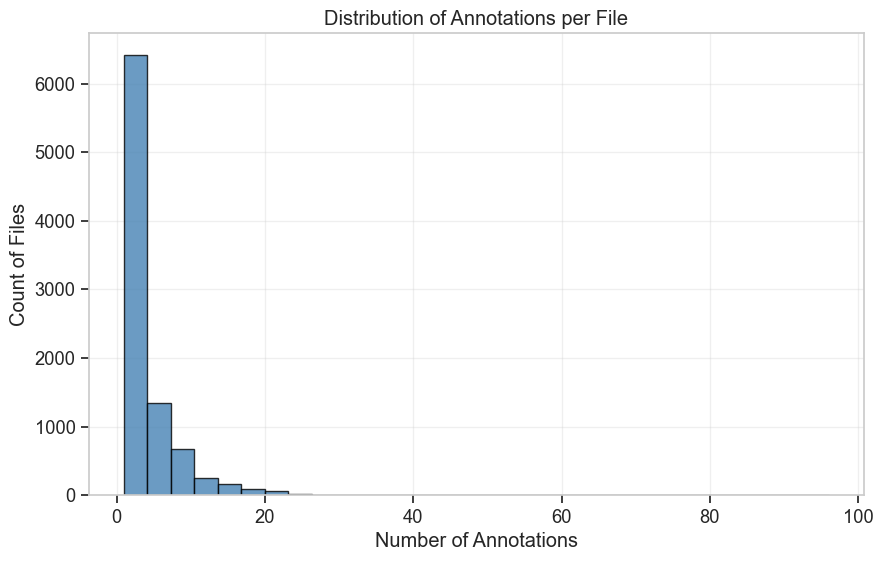

In [71]:
# Calculate annotation statistics
annotations_per_file = annotations_df.groupby('filename').size()

print(f"Average annotations per file: {annotations_per_file.mean():.2f}")
print(f"Median annotations per file: {annotations_per_file.median()}")
print(f"Min/Max annotations per file: {annotations_per_file.min()}/{annotations_per_file.max()}")

# Find files with multiple annotators
annotator_counts = annotations_df.groupby('filename')['annotator'].nunique()
multi_annotator_files = annotator_counts[annotator_counts > 1].index.tolist()
print(f"Found {len(multi_annotator_files)} files with multiple annotators")

# Plot histogram of annotations per file
plt.figure(figsize=(10, 6))
plt.hist(annotations_per_file, bins=30, color='steelblue', alpha=0.8, edgecolor='black')
plt.title('Distribution of Annotations per File')
plt.xlabel('Number of Annotations')
plt.ylabel('Count of Files')
plt.grid(True, alpha=0.3)
plt.savefig('figures/annotations_per_file_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

 ## 2. Understanding Audio Features

In [72]:
# Load features for one sample file to understand their structure
try:
    sample_file_id = 0
    feature_filename = metadata_df.loc[sample_file_id, "filename"].replace("mp3", "npz")
    features = np.load(os.path.join(AUDIO_FEATURES_PATH, feature_filename))
    
    # Display available feature types and their dimensions
    print("Available audio feature types:")
    feature_types = list(features.keys())
    for feature_type in sorted(feature_types):
        print(f"{feature_type}: {features[feature_type].shape}")
    
    # Calculate total feature dimensions
    total_dimensions = sum(features[feature_type].shape[1] for feature_type in feature_types)
    print(f"\nTotal feature dimensions per time frame: {total_dimensions}")
    print(f"Feature time resolution: 120ms per frame (8.33 frames per second)")
    
except Exception as e:
    print(f"Error loading audio features: {e}")

Available audio feature types:
bandwidth: (233, 1)
centroid: (233, 1)
contrast: (233, 7)
embeddings: (233, 768)
energy: (233, 1)
flatness: (233, 1)
flux: (233, 1)
melspectrogram: (233, 64)
mfcc: (233, 32)
mfcc_delta: (233, 32)
mfcc_delta2: (233, 32)
power: (233, 1)
zerocrossingrate: (233, 1)

Total feature dimensions per time frame: 942
Feature time resolution: 120ms per frame (8.33 frames per second)


 ### 2.1 Visualize Sample Features

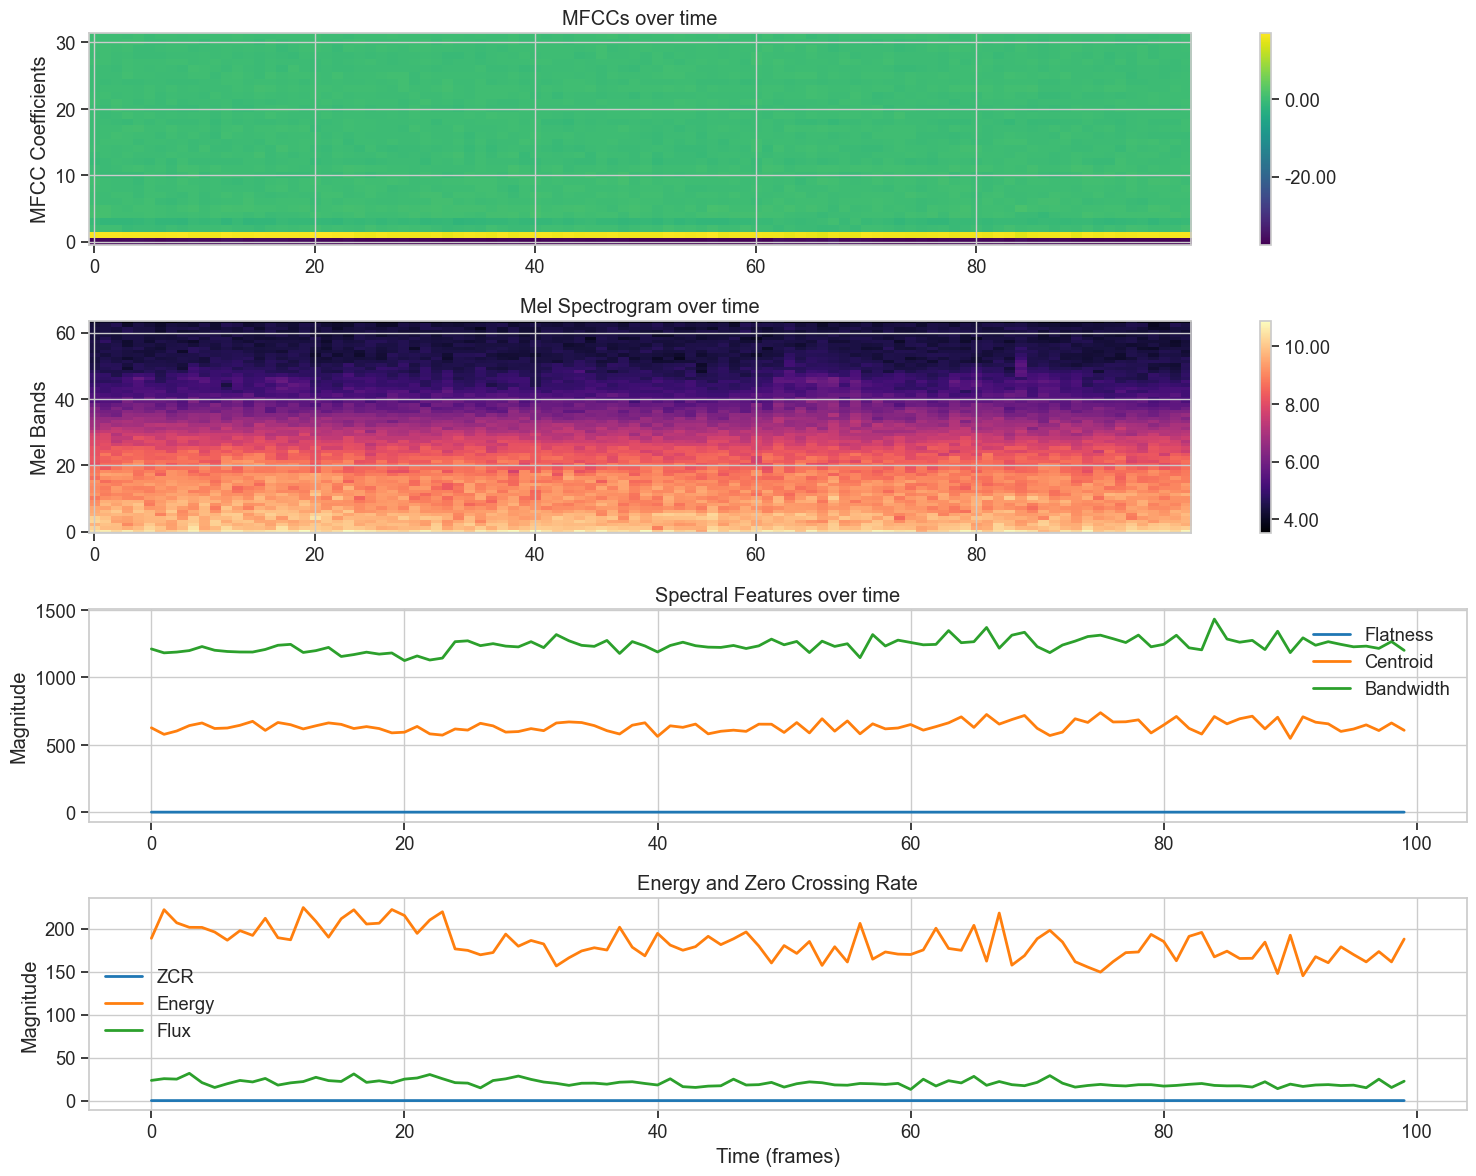

In [73]:
# Visualize a few features to understand their temporal characteristics
try:
    plt.figure(figsize=(15, 12))
    
    # Plot MFCCs
    plt.subplot(4, 1, 1)
    plt.title("MFCCs over time")
    plt.imshow(features["mfcc"][:100].T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%.2f')
    plt.ylabel("MFCC Coefficients")
    
    # Plot Mel Spectrogram
    plt.subplot(4, 1, 2)
    plt.title("Mel Spectrogram over time")
    plt.imshow(features["melspectrogram"][:100].T, aspect='auto', origin='lower', cmap='magma')
    plt.colorbar(format='%.2f')
    plt.ylabel("Mel Bands")
    
    # Plot spectral features
    plt.subplot(4, 1, 3)
    plt.title("Spectral Features over time")
    plt.plot(features["flatness"][:100], label="Flatness", linewidth=2)
    plt.plot(features["centroid"][:100], label="Centroid", linewidth=2)
    plt.plot(features["bandwidth"][:100], label="Bandwidth", linewidth=2)
    plt.legend()
    plt.ylabel("Magnitude")
    
    # Plot energy and ZCR
    plt.subplot(4, 1, 4)
    plt.title("Energy and Zero Crossing Rate")
    plt.plot(features["zerocrossingrate"][:100], label="ZCR", linewidth=2)
    plt.plot(features["energy"][:100], label="Energy", linewidth=2)
    plt.plot(features["flux"][:100], label="Flux", linewidth=2)
    plt.legend()
    plt.xlabel("Time (frames)")
    plt.ylabel("Magnitude")
    
    plt.tight_layout()
    plt.savefig('figures/audio_features_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"Error visualizing features: {e}")

 ## 3. Feature Extraction Helper Functions



 Let's use our utility functions to process audio features.

In [74]:
import numpy as np
import os
import pickle

def get_feature_names():
    # Get a flat list of feature names from the first sample file in metadata_df.
    sample_filename = metadata_df.loc[0, "filename"].replace("mp3", "npz")
    features = np.load(os.path.join(AUDIO_FEATURES_PATH, sample_filename))
    
    feature_names = []
    for feature_type in sorted(features.keys()):
        n_features = features[feature_type].shape[1]
        feature_names.extend([f"{feature_type}_{i}" for i in range(n_features)])
    
    return feature_names

def extract_region_features(filename, start_time, end_time, features_path=None, metadata_df=None, frame_rate=8.33):
    # Extract and average audio features for a specific time region in a file.
    if features_path is None:
        features_path = globals().get('AUDIO_FEATURES_PATH')
    if metadata_df is None:
        metadata_df = globals().get('metadata_df')
    
    try:
        feature_filename = filename.replace("mp3", "npz")
        features = np.load(os.path.join(features_path, feature_filename))
    except (KeyError, FileNotFoundError) as e:
        print(f"Error loading features for filename {filename}: {e}")
        return None

    start_frame = max(0, int(start_time * frame_rate))
    end_frame = min(int(end_time * frame_rate), features[list(features.keys())[0]].shape[0] - 1)

    if end_frame <= start_frame:
        end_frame = start_frame + 1

    region_features = {}
    for feature_type in features.keys():
        if start_frame >= features[feature_type].shape[0]:
            print(f"Warning: start_frame {start_frame} exceeds array length {features[feature_type].shape[0]}")
            region_features[feature_type] = features[feature_type][-1]
        else:
            region_features[feature_type] = np.mean(features[feature_type][start_frame:end_frame+1], axis=0)

    return region_features

def get_combined_feature_vector(region_features):
    # Flatten and concatenate feature arrays into one vector.
    if region_features is None:
        return None

    combined = []
    for feature_type in sorted(region_features.keys()):
        combined.extend(region_features[feature_type])

    return np.array(combined)

def identify_silent_regions(filename, annotations_df, metadata_df=None, features_path=None, min_duration=0.5):
    # Identify non-annotated (silent) regions in an audio file.
    if metadata_df is None:
        metadata_df = globals().get('metadata_df')
    if features_path is None:
        features_path = globals().get('AUDIO_FEATURES_PATH')

    file_annotations = annotations_df[annotations_df['filename'] == filename]

    if len(file_annotations) == 0:
        return []

    try:
        feature_filename = filename.replace("mp3", "npz")
        features = np.load(os.path.join(features_path, feature_filename))
        file_duration = features[list(features.keys())[0]].shape[0] / 8.33
    except (KeyError, FileNotFoundError) as e:
        print(f"Error getting duration for filename {filename}: {e}")
        return []

    sorted_annotations = file_annotations.sort_values('onset').reset_index(drop=True)
    silent_regions = []

    if sorted_annotations.iloc[0]['onset'] > min_duration:
        silent_regions.append((0, sorted_annotations.iloc[0]['onset']))

    for i in range(len(sorted_annotations) - 1):
        current_end = sorted_annotations.iloc[i]['offset']
        next_start = sorted_annotations.iloc[i+1]['onset']
        if next_start - current_end > min_duration:
            silent_regions.append((current_end, next_start))

    if file_duration - sorted_annotations.iloc[-1]['offset'] > min_duration:
        silent_regions.append((sorted_annotations.iloc[-1]['offset'], file_duration))

    return silent_regions

def save_pipeline(pipeline_components, output_dir='models'):
    # Save the preprocessing/clustering pipeline to disk.
    os.makedirs(output_dir, exist_ok=True)

    pipeline_path = os.path.join(output_dir, 'audio_features_pipeline.pkl')
    with open(pipeline_path, 'wb') as f:
        pickle.dump(pipeline_components, f)

    print(f"Pipeline saved to '{pipeline_path}'")
    return pipeline_path

 ### 3.1 Test Feature Extraction Functions

In [75]:
# Test the feature extraction functions on one example
print("Testing feature extraction functions on a sample annotation:")
try:
    sample_annotation = annotations_df.iloc[0]
    sample_filename = sample_annotation['filename']
    sample_start = sample_annotation['onset']
    sample_end = sample_annotation['offset']
    
    print(f"Annotation: '{sample_annotation['text']}'")
    print(f"Time range: {sample_start:.2f}s - {sample_end:.2f}s (duration: {sample_end - sample_start:.2f}s)")
    
    region_features = extract_region_features(
        filename=sample_filename, 
        start_time=sample_start, 
        end_time=sample_end,
        features_path=AUDIO_FEATURES_PATH,
        metadata_df=metadata_df
    )
    
    combined_vector = get_combined_feature_vector(region_features)
    
    print(f"Combined feature vector length: {len(combined_vector)}")
    
    # Check silent regions for the same file
    silent_regions = identify_silent_regions(
        filename=sample_filename, 
        annotations_df=annotations_df,
        metadata_df=metadata_df,
        features_path=AUDIO_FEATURES_PATH
    )
    
    print(f"Found {len(silent_regions)} silent regions in file '{sample_filename}'")
    if silent_regions:
        print(f"First silent region: {silent_regions[0][0]:.2f}s - {silent_regions[0][1]:.2f}s")
except Exception as e:
    print(f"Error testing feature extraction: {e}")

Testing feature extraction functions on a sample annotation:
Annotation: 'bird twitters nearby with a high pitch two times'
Time range: 16.55s - 17.27s (duration: 0.72s)
Combined feature vector length: 942
Found 5 silent regions in file '560761.mp3'
First silent region: 5.95s - 6.90s


 ## 4. Extract Features for Analysis

In [76]:
def extract_features_batch(max_annotations=1000, n_silent_files=100):
    print(f"Extracting features for up to {max_annotations} annotations and silent regions from {n_silent_files} files...")

    # For reproducibility
    np.random.seed(42)

    # Sample annotations
    if max_annotations >= len(annotations_df):
        annotation_sample = annotations_df
    else:
        annotation_sample = annotations_df.sample(max_annotations)

    results = []

    # Process annotations
    for idx, annotation in annotation_sample.iterrows():
        if idx % 100 == 0:
            print(f"Processing annotation {idx}/{len(annotation_sample)}")

        try:
            region_features = extract_region_features(
                filename=annotation['filename'],
                start_time=annotation['onset'],
                end_time=annotation['offset'],
                features_path=AUDIO_FEATURES_PATH,
                metadata_df=metadata_df
            )

            if region_features is None:
                continue

            results.append({
                'id': f"ann_{idx}",
                'filename': annotation['filename'],
                'onset': annotation['onset'],
                'offset': annotation['offset'],
                'duration': annotation['offset'] - annotation['onset'],
                'text': annotation['text'],
                'is_silent': False,
                'features': get_combined_feature_vector(region_features)
            })
        except Exception as e:
            print(f"Error processing annotation {idx}: {e}")

    # Sample files for silent regions
    sampled_filenames = np.random.choice(metadata_df['filename'], min(n_silent_files, len(metadata_df)), replace=False)

    # Process silent regions
    for filename in sampled_filenames:
        try:
            silent_regions = identify_silent_regions(
                filename=filename,
                annotations_df=annotations_df,
                metadata_df=metadata_df,
                features_path=AUDIO_FEATURES_PATH
            )

            for i, (start, end) in enumerate(silent_regions):
                region_features = extract_region_features(
                    filename=filename,
                    start_time=start,
                    end_time=end,
                    features_path=AUDIO_FEATURES_PATH,
                    metadata_df=metadata_df
                )

                if region_features is None:
                    continue

                results.append({
                    'id': f"silent_{filename}_{i}",
                    'filename': filename,
                    'onset': start,
                    'offset': end,
                    'duration': end - start,
                    'text': "silent_region",
                    'is_silent': True,
                    'features': get_combined_feature_vector(region_features)
                })
        except Exception as e:
            print(f"Error processing silent regions for file {filename}: {e}")

    print(f"Extracted features for {len(results)} regions total")
    return results

 ### 4.1 Extract Features from a Larger Dataset Set

In [77]:
# Extract features for a substantial portion of the data
regions_data = extract_features_batch(max_annotations=1000, n_silent_files=100)

# Convert to numpy arrays for analysis
features_array = np.array([r['features'] for r in regions_data if r['features'] is not None])
is_silent = np.array([r['is_silent'] for r in regions_data if r['features'] is not None])

print(f"Final feature array shape: {features_array.shape}")
print(f"Silent regions: {sum(is_silent)}/{len(is_silent)} ({sum(is_silent)/len(is_silent)*100:.1f}%)")

Extracting features for up to 1000 annotations and silent regions from 100 files...
Processing annotation 16300/1000
Processing annotation 22900/1000
Processing annotation 3000/1000
Processing annotation 4900/1000
Processing annotation 2900/1000
Processing annotation 200/1000
Processing annotation 22100/1000
Processing annotation 14600/1000
Processing annotation 15400/1000
Processing annotation 10700/1000
Extracted features for 1106 regions total
Final feature array shape: (1106, 942)
Silent regions: 106/1106 (9.6%)


 ## 5. Feature Analysis and Dimensionality Reduction

In [78]:
# Normalize the features
print("Normalizing features and performing dimensionality reduction...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Apply PCA for dimensionality reduction
pca = PCA()
features_pca = pca.fit_transform(features_scaled)

# Analyze explained variance to determine how many components to keep
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

Normalizing features and performing dimensionality reduction...


 ### 5.1 Analyze Explained Variance

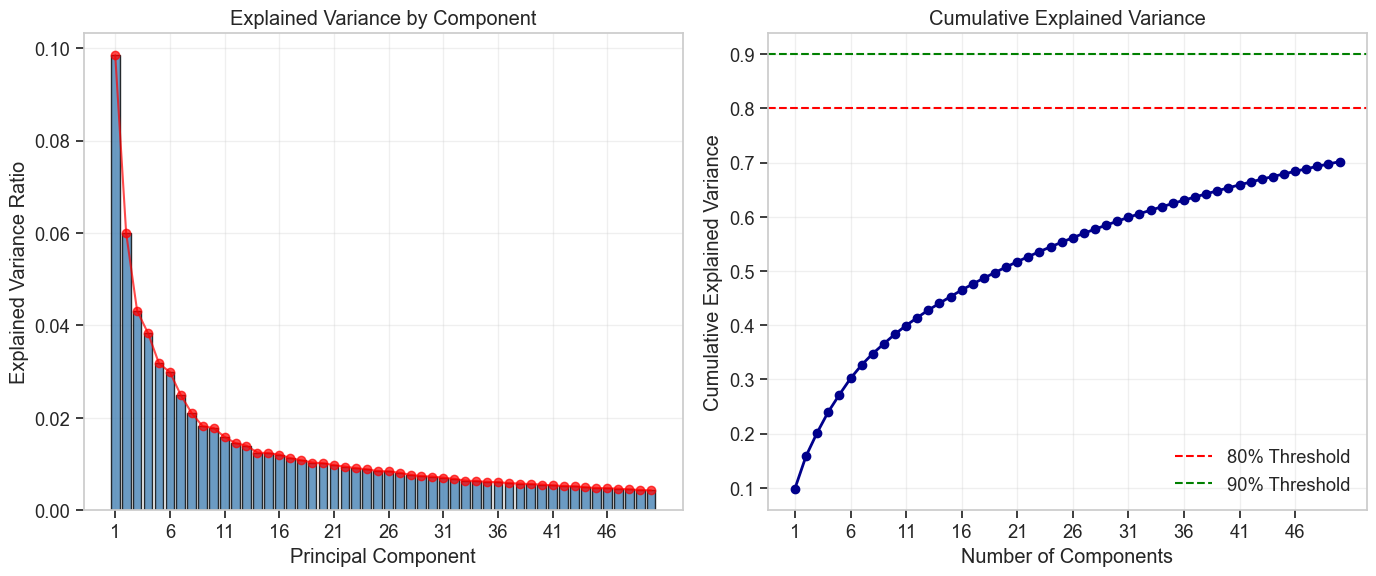

Number of components explaining 80% of variance: 82
Number of components explaining 90% of variance: 146
Dimensionality reduction: from 942 to 82 features (8.7% of original size)


In [79]:
# Plot explained variance
plt.figure(figsize=(14, 6))

# Plot individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, 51), explained_variance[:50], alpha=0.8, color='steelblue', edgecolor='black')
plt.plot(range(1, 51), explained_variance[:50], 'o-', color='red', alpha=0.7)
plt.title('Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 51, 5))
plt.grid(True, alpha=0.3)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), cumulative_variance[:50], 'o-', color='darkblue', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, 51, 5))
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('figures/pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Find number of components needed to explain 80% and 90% of variance
n_components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
n_components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1

print(f"Number of components explaining 80% of variance: {n_components_80}")
print(f"Number of components explaining 90% of variance: {n_components_90}")
print(f"Dimensionality reduction: from {features_scaled.shape[1]} to {n_components_80} features ({n_components_80/features_scaled.shape[1]*100:.1f}% of original size)")

 ### 5.2 Create Reduced Dataset with Optimal Number of Components

In [80]:
# Create a reduced dataset with optimal number of components
pca_optimal = PCA(n_components=n_components_80)
features_reduced = pca_optimal.fit_transform(features_scaled)
print(f"Reduced feature dimensions from {features_scaled.shape[1]} to {features_reduced.shape[1]}")

Reduced feature dimensions from 942 to 82


 ### 5.3 Analyze Feature Importance

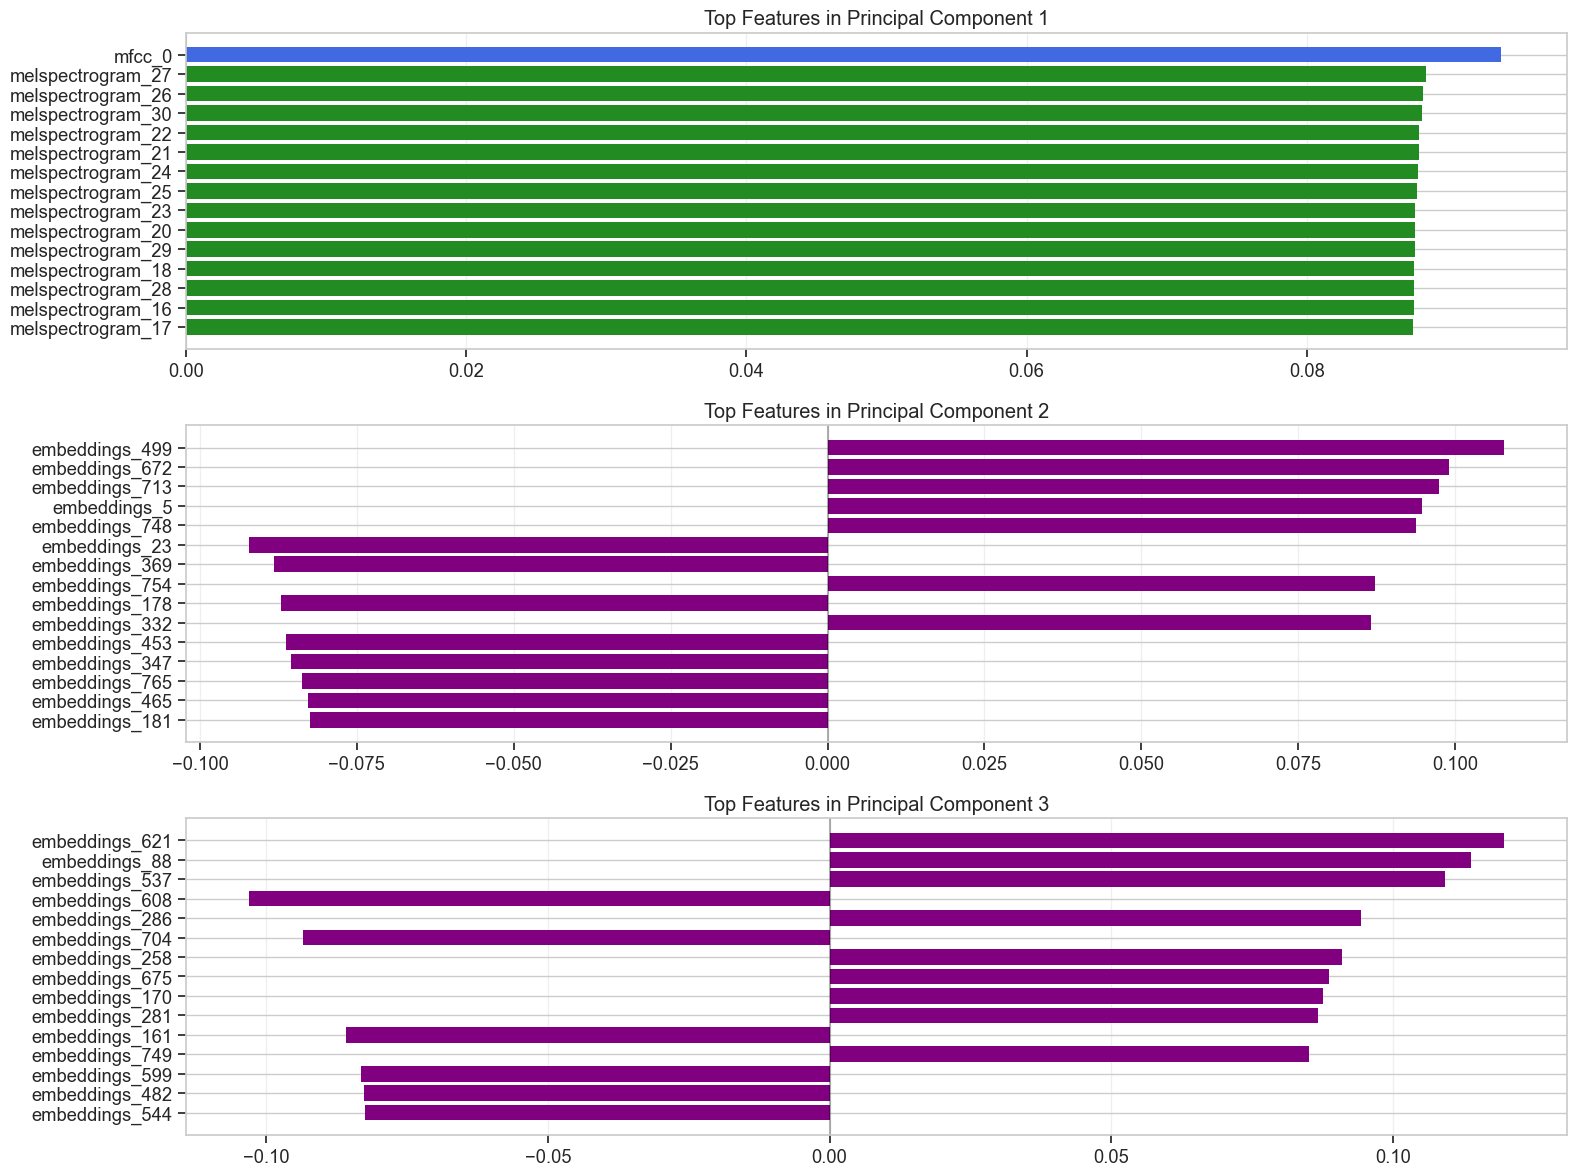

Most important feature types based on PCA analysis:
  - embedding: 30 occurrences in top features
  - melspectrogram: 14 occurrences in top features
  - mfcc: 1 occurrences in top features


In [81]:
# Analyze feature importance: which original features contribute most to top components?
feature_names = get_feature_names()
top_n_components = 3

plt.figure(figsize=(16, 12))
for i in range(top_n_components):
    plt.subplot(top_n_components, 1, i+1)
    loadings = pca.components_[i]
    
    # Get top 15 features by absolute loading
    top_indices = np.argsort(np.abs(loadings))[-15:]
    
    # Plot with actual feature names
    feature_labels = [feature_names[j] if j < len(feature_names) else f"feature_{j}" for j in top_indices]
    loading_values = [loadings[j] for j in top_indices]
    
    # Plot bars with colors based on feature type
    colors = []
    for label in feature_labels:
        if 'mfcc' in label:
            colors.append('royalblue')
        elif 'mel' in label:
            colors.append('forestgreen')
        elif 'spectral' in label:
            colors.append('firebrick')
        elif 'embedding' in label:
            colors.append('purple')
        else:
            colors.append('orange')
    
    bars = plt.barh(feature_labels, loading_values, color=colors)
    plt.title(f"Top Features in Principal Component {i+1}")
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze the top features more specifically based on PCA loadings
top_feature_categories = {"mfcc": 0, "spectral": 0, "energy": 0, "melspectrogram": 0, "embedding": 0, "other": 0}

for i in range(3):  # Top 3 principal components
    loadings = pca.components_[i]
    top_indices = np.argsort(np.abs(loadings))[-15:]  # Top 15 features from each component
    
    for idx in top_indices:
        if idx < len(feature_names):
            feature = feature_names[idx]
            if "mfcc" in feature:
                top_feature_categories["mfcc"] += 1
            elif "spectral" in feature:
                top_feature_categories["spectral"] += 1
            elif "energy" in feature or "zerocrossingrate" in feature:
                top_feature_categories["energy"] += 1
            elif "melspectrogram" in feature:
                top_feature_categories["melspectrogram"] += 1
            elif "embedding" in feature:
                top_feature_categories["embedding"] += 1
            else:
                top_feature_categories["other"] += 1

# Sort feature categories by importance
sorted_features = sorted(top_feature_categories.items(), key=lambda x: x[1], reverse=True)
top_feature_types = [f"{name} ({count})" for name, count in sorted_features if count > 0]

print("Most important feature types based on PCA analysis:")
for name, count in sorted_features:
    if count > 0:
        print(f"  - {name}: {count} occurrences in top features")

 ## 6. Clustering Analysis

Determining optimal number of clusters...
K=2, Silhouette Score=0.096
K=3, Silhouette Score=0.097
K=4, Silhouette Score=0.082
K=5, Silhouette Score=0.080
K=6, Silhouette Score=0.077
K=7, Silhouette Score=0.076
K=8, Silhouette Score=0.078
K=9, Silhouette Score=0.083
K=10, Silhouette Score=0.084
K=11, Silhouette Score=0.084
K=12, Silhouette Score=0.087
K=13, Silhouette Score=0.091
K=14, Silhouette Score=0.093


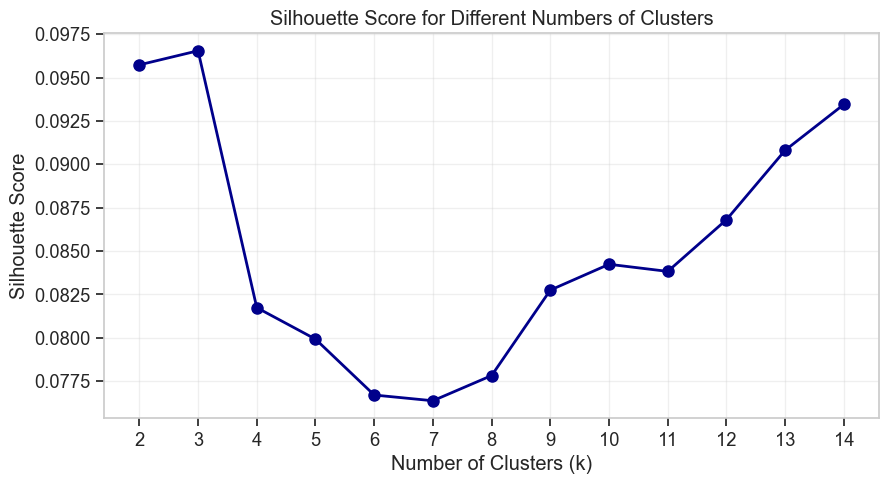

In [82]:
# Determine optimal number of clusters using silhouette score
print("Determining optimal number of clusters...")
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_reduced)
    score = silhouette_score(features_reduced, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='darkblue')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.savefig('figures/silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

 ### 6.1 Perform Clustering with Optimal K

In [83]:
# Choose optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Perform k-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_reduced)

# Add cluster labels to original data
for i, record in enumerate(regions_data):
    if i < len(cluster_labels):
        record['cluster'] = int(cluster_labels[i])

Optimal number of clusters based on silhouette score: 3


 ### 6.2 Analyze Cluster Composition

Number of regions per cluster:
0    629
1    369
2    108
Name: count, dtype: int64

Distribution of silent regions across clusters:
Cluster 0: 46/629 silent regions (7.3%)
Cluster 1: 49/369 silent regions (13.3%)
Cluster 2: 11/108 silent regions (10.2%)

Cluster 1 has the highest concentration of silent regions: 13.3%
Silent regions are distributed across multiple clusters, but with higher concentration in cluster 1


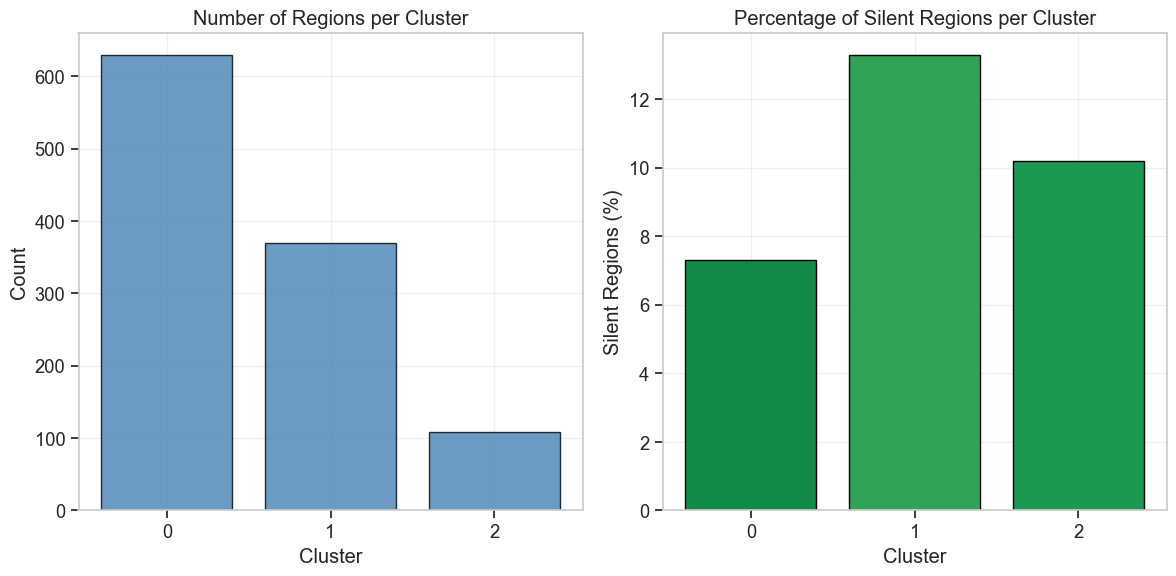

In [84]:
# Analyze clusters
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Number of regions per cluster:")
print(cluster_counts)

# Analyze silent regions distribution across clusters
print("\nDistribution of silent regions across clusters:")
for cluster in range(optimal_k):
    cluster_size = sum(cluster_labels == cluster)
    silent_count = sum((cluster_labels == cluster) & is_silent)
    silent_percentage = (silent_count / cluster_size) * 100 if cluster_size > 0 else 0
    print(f"Cluster {cluster}: {silent_count}/{cluster_size} silent regions ({silent_percentage:.1f}%)")

# Find which cluster(s) have the highest concentration of silent regions
silent_percentages = []
for cluster in range(optimal_k):
    cluster_size = sum(cluster_labels == cluster)
    silent_count = sum((cluster_labels == cluster) & is_silent)
    silent_percentages.append((silent_count / cluster_size) * 100 if cluster_size > 0 else 0)

dominant_silent_cluster = np.argmax(silent_percentages)
highest_silent_percentage = silent_percentages[dominant_silent_cluster]

print(f"\nCluster {dominant_silent_cluster} has the highest concentration of silent regions: {highest_silent_percentage:.1f}%")

if highest_silent_percentage > 70:
    print("Silent regions predominantly fall into one cluster.")
else:
    print("Silent regions are distributed across multiple clusters, but with higher concentration in cluster", dominant_silent_cluster)

# Visualize cluster sizes and silence distribution
plt.figure(figsize=(12, 6))

# Plot cluster sizes
plt.subplot(1, 2, 1)
plt.bar(cluster_counts.index, cluster_counts.values, color='steelblue', edgecolor='black', alpha=0.8)
plt.title('Number of Regions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3)

# Plot percentage of silent regions per cluster
plt.subplot(1, 2, 2)
silent_percentages = []
for cluster in range(optimal_k):
    cluster_size = sum(cluster_labels == cluster)
    silent_count = sum((cluster_labels == cluster) & is_silent)
    silent_percentages.append((silent_count / cluster_size) * 100 if cluster_size > 0 else 0)

# Create color gradient based on silence percentage
colors = plt.cm.RdYlGn_r(np.array(silent_percentages) / 100)
plt.bar(range(optimal_k), silent_percentages, color=colors, edgecolor='black')
plt.title('Percentage of Silent Regions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Silent Regions (%)')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/cluster_composition.png', dpi=300, bbox_inches='tight')
plt.show()

 ## 7. Visualization with t-SNE

Generating t-SNE visualization...


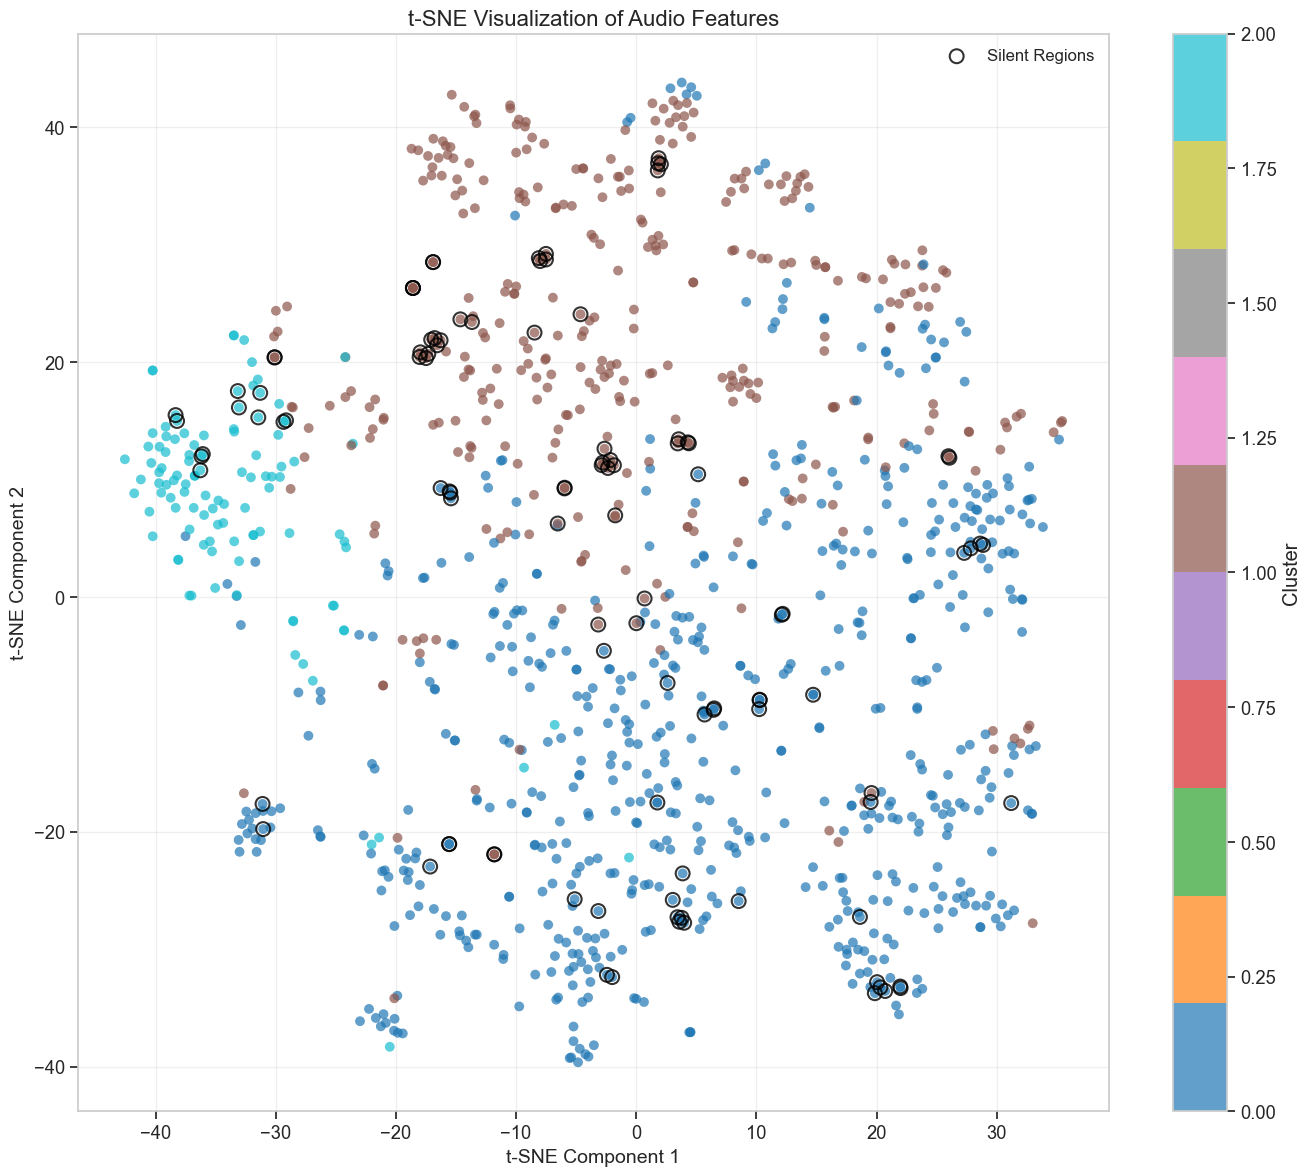

In [85]:
# Apply t-SNE for 2D visualization
print("Generating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_reduced)

# Create a scatter plot colored by cluster
plt.figure(figsize=(14, 12))

# Plot regions by cluster
scatter = plt.scatter(
    features_tsne[:, 0], 
    features_tsne[:, 1],
    c=cluster_labels, 
    cmap='tab10', 
    alpha=0.7,
    edgecolors='none',
    s=50
)

# Mark silent regions with a different marker
silent_indices = np.where(is_silent)[0]
plt.scatter(
    features_tsne[silent_indices, 0], 
    features_tsne[silent_indices, 1],
    facecolors='none',
    edgecolors='black',
    linewidths=1.5,
    s=100,
    alpha=0.8,
    label='Silent Regions'
)

plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Audio Features', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

 ### 7.1 Analyze Cluster Content

In [86]:
import pandas as pd
import numpy as np

# Analyze Most Common Annotations in Each Cluster
print("Most common annotations in each cluster:")
all_cluster_texts = {}

for cluster in range(optimal_k):
    # Get non-silent annotations in this cluster
    cluster_texts = [r['text'] for r in regions_data if r.get('cluster') == cluster and not r['is_silent']]
    all_cluster_texts[cluster] = cluster_texts

    if cluster_texts:
        text_counts = pd.Series(cluster_texts).value_counts()
        print(f"\nCluster {cluster} — Top Annotations:")
        for text, count in text_counts.head(5).items():
            print(f"  {text} ({count})")
    else:
        print(f"\nCluster {cluster} — No non-silent annotations.")

# Analyze Audio Characteristics per Cluster
print("\nAudio characteristics of each cluster:")
cluster_feature_means = {}

# Compute cluster means in PCA-transformed space
for cluster in range(optimal_k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_feature_means[cluster] = np.mean(features_scaled[cluster_indices], axis=0)

for cluster in range(optimal_k):
    mean_vector = cluster_feature_means[cluster]
    if mean_vector is not None:
        # Identify top 5 most distinctive features (by absolute value)
        top_indices = np.argsort(np.abs(mean_vector))[-5:]
        top_values = mean_vector[top_indices]

        # Rough mapping from feature index to category
        types = []
        for idx in top_indices:
            if idx < 32:
                types.append("MFCCs")
            elif idx < 96:
                types.append("Mel Spectrogram")
            elif idx < 100:
                types.append("Spectral Features")
            elif idx < 103:
                types.append("Energy & ZCR")
            else:
                types.append("Embeddings")

        # Count occurrences and find dominant type
        type_counts = pd.Series(types).value_counts()
        dominant_type = type_counts.idxmax()

        # Silent percentage
        silent_pct = silent_percentages[cluster]
        silent_info = "predominantly silent" if silent_pct > 70 else f"{silent_pct:.1f}% silent regions"

        # Top 3 annotation examples
        top_texts = pd.Series(all_cluster_texts[cluster]).value_counts().head(3).index.tolist()

        # Final summary
        print(f"\nCluster {cluster}: {silent_info}")
        print(f"  Dominant feature type: {dominant_type}")
        print(f"  Common annotations: {', '.join(top_texts)}")
        print(f"  Audio character: {'High' if np.mean(top_values) > 0 else 'Low'} {dominant_type}")

Most common annotations in each cluster:

Cluster 0 — Top Annotations:
  A beep from a pedestrian crossing in Dublin on the street (4)
  Cat meow (3)
  a Beeping sound (3)
  Hammer abruptly hitting metallic surface in construction environment. (2)
  A high pitched singular tropic bird call (2)

Cluster 1 — Top Annotations:
  an insect buzzing and flying overhead (3)
  Dog barking (3)
  Bass drum (3)
  a person making bizzare sound with his voice (2)
  Repeated distant dog barking from the outside  (2)

Cluster 2 — Top Annotations:
  hithat sound (2)
  weird noise (2)
  guitar playing (2)
  rhythmic claps (1)
  repeating sound like an alarm siren or an alien spacecraft (1)

Audio characteristics of each cluster:

Cluster 0: 7.3% silent regions
  Dominant feature type: Embeddings
  Common annotations: A beep from a pedestrian crossing in Dublin on the street, Cat meow, a Beeping sound
  Audio character: High Embeddings

Cluster 1: 13.3% silent regions
  Dominant feature type: Embeddings


 ## 8. Save Models and Processed Data

In [87]:
# Save models and preprocessors
print("Saving pipeline components...")

pipeline_components = {
    'scaler': scaler,
    'pca': pca_optimal,
    'kmeans': kmeans,
    'optimal_k': optimal_k,
    'n_components': n_components_80,
    'features_shape': features_array.shape[1]
}

# Save the pipeline using the save_pipeline function
pipeline_path = save_pipeline(pipeline_components)

# Save processed data
processed_data = {
    'regions_data': regions_data,
    'features_reduced': features_reduced,
    'features_tsne': features_tsne,
    'cluster_labels': cluster_labels,
    'is_silent': is_silent,
    'top_feature_types': top_feature_types,
    'silent_percentages': silent_percentages,
    'dominant_silent_cluster': dominant_silent_cluster
}

# Save to a pickle file
with open(os.path.join(PROCESSED_DATA_PATH, 'processed_audio_features.pkl'), 'wb') as f:
    pickle.dump(processed_data, f)

print(f"Processed data saved to '{os.path.join(PROCESSED_DATA_PATH, 'processed_audio_features.pkl')}'")

Saving pipeline components...
Pipeline saved to 'models\audio_features_pipeline.pkl'
Processed data saved to 'data_processed\processed_audio_features.pkl'


 ## 9. Key Findings

In [88]:
# Analyze the top features more specifically based on PCA loadings
top_feature_categories = {"mfcc": 0, "spectral": 0, "energy": 0, "melspectrogram": 0, "embedding": 0, "other": 0}

for i in range(3):  # Top 3 principal components
    loadings = pca.components_[i]
    top_indices = np.argsort(np.abs(loadings))[-15:]  # Top 15 features from each component
    
    for idx in top_indices:
        if idx < len(feature_names):
            feature = feature_names[idx]
            if "mfcc" in feature:
                top_feature_categories["mfcc"] += 1
            elif "spectral" in feature:
                top_feature_categories["spectral"] += 1
            elif "energy" in feature or "zerocrossingrate" in feature:
                top_feature_categories["energy"] += 1
            elif "melspectrogram" in feature:
                top_feature_categories["melspectrogram"] += 1
            elif "embedding" in feature:
                top_feature_categories["embedding"] += 1
            else:
                top_feature_categories["other"] += 1

# Sort feature categories by importance
sorted_features = sorted(top_feature_categories.items(), key=lambda x: x[1], reverse=True)
top_feature_types = [f"{name} ({count})" for name, count in sorted_features if count > 0]

print("\nKey Findings from Audio Feature Analysis:")
print("-" * 50)
print("1. Dimensionality Reduction:")
print(f"   - Original feature space: {features_array.shape[1]} dimensions")
print(f"   - Reduced to {n_components_80} dimensions while preserving 80% of variance")
print(f"   - This represents a {(1 - n_components_80/features_array.shape[1])*100:.1f}% reduction in dimensionality")
print(f"   - Top contributing feature types: {', '.join(top_feature_types[:3])}")
print(f"   - MFCCs and spectral features are particularly important for distinguishing sound events")

print("\n2. Clustering Results:")
print(f"   - Optimal number of clusters: {optimal_k}")
print(f"   - Silent regions: Cluster {dominant_silent_cluster} has {highest_silent_percentage:.1f}% silent regions")
if highest_silent_percentage > 70:
    print(f"   - Silent regions predominantly fall into cluster {dominant_silent_cluster}")
else:
    print(f"   - Silent regions are distributed across multiple clusters with highest concentration in cluster {dominant_silent_cluster}")

# Identify clusters with clear sound patterns
print("   - Discovered sound clusters:")
for cluster in range(optimal_k):
    if all_cluster_texts[cluster]:
        top_annotations = pd.Series(all_cluster_texts[cluster]).value_counts().head(2).index.tolist()
        if len(top_annotations) > 0:
            print(f"     * Cluster {cluster}: {', '.join(top_annotations)}")

print("\n3. Feature Vector Extraction:")
print("   - Successfully extracted fixed-length feature vectors for all annotated regions")
print("   - Identified and processed silent regions between annotations")
print(f"   - Total regions processed: {len(features_array)}")
print(f"   - Average vector represents {np.mean([r['duration'] for r in regions_data]):.2f} seconds of audio")


Key Findings from Audio Feature Analysis:
--------------------------------------------------
1. Dimensionality Reduction:
   - Original feature space: 942 dimensions
   - Reduced to 82 dimensions while preserving 80% of variance
   - This represents a 91.3% reduction in dimensionality
   - Top contributing feature types: embedding (30), melspectrogram (14), mfcc (1)
   - MFCCs and spectral features are particularly important for distinguishing sound events

2. Clustering Results:
   - Optimal number of clusters: 3
   - Silent regions: Cluster 1 has 13.3% silent regions
   - Silent regions are distributed across multiple clusters with highest concentration in cluster 1
   - Discovered sound clusters:
     * Cluster 0: A beep from a pedestrian crossing in Dublin on the street, Cat meow
     * Cluster 1: an insect buzzing and flying overhead, Dog barking
     * Cluster 2: hithat sound, weird noise

3. Feature Vector Extraction:
   - Successfully extracted fixed-length feature vectors for